Enrico Convento -- id:2023572

If you want to avoid to re-run the training load:


*   vae.pth
*   vae_2dim.pth



#VAE

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F  

import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import train_test_split, KFold

In [3]:
use_gpu = True
# Check if the GPU is available
device = torch.device("cuda") if (torch.cuda.is_available() and use_gpu) else torch.device("cpu")
if use_gpu:
  print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")
else:
  print(f'Training device: {device}')

Training device: cuda: Tesla K80


## Dataset

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
all_train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #ReplaceLabel()
])



all_train_dataset.transform = train_transform
test_dataset.transform = train_transform


val_perc = 0.2
shuffle = False

## Train-Validation split
train_dataset, val_dataset = train_test_split(all_train_dataset, test_size=val_perc, shuffle=shuffle)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)
print('Training data:', len(train_dataset), '\nValidation data:', len(val_dataset), '\nTest data: ', len(test_dataset))

## Encoder - Decoder

In [6]:
class Encoder(nn.Module):
  def __init__(self, latent_dims = 5):
      super(Encoder, self).__init__()
      c = 8
      self.latent_dims = latent_dims
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
      self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
      self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=self.latent_dims)
      self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=self.latent_dims)
          
  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
      x_mu = self.fc_mu(x)
      x_logvar = self.fc_logvar(x)
      return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dims = 5):
        super(Decoder, self).__init__()
        c = 8
        self.latent_dims = latent_dims
        self.fc = nn.Linear(in_features=self.latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 8*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps  8x2x7x7 = 784
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

## VAE system

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims = 5):
        super(VariationalAutoencoder, self).__init__()
        self.latent_dims = latent_dims
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

## Loss function
The loss function associated to a VAE is given by:
$$
\mathcal{L}(\theta, \phi ; \mathbf{x}, \mathbf{z}, \beta)=\mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\log p_{\theta}(\mathbf{x} \mid \mathbf{z})\right]-\beta D_{K L}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p(\mathbf{z})\right)
$$

Where the first term is called reconstruction loss while the second one is called regularization term in this case for the first is used the L2 norm and the second is the KL divergence. The term $β$ could be used to implement a $β$-VAE

In [8]:
variational_beta = 1
def vae_loss(recon_x, x, mu, logvar):
   
    #recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    recon_loss = ((x - recon_x)**2).sum()

    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    


## Training

In [9]:
class Training(object):
  '''
  Class for training the Network. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    net
    optimizer: needs to be already linked to the net
    train_dataloader: training Dataloader
    val_dataloader: validation Dataloader
  '''
  def __init__(self, net, optimizer, train_dataloader, val_dataloader):
    self.net = net
    self.optimizer = optimizer

    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader

    self.train_loss_log = []
    self.val_loss_log = []


  def stop_learning(self,epoch_num):
    return False


  ### Training function
  def train_epoch(self):
      # Set train mode for both the encoder and the decoder
      self.net.train()
      train_loss = []

      num_batches = 0
      # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
      for image_batch, _ in self.train_dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
          # Move tensor to the proper device
          image_batch = image_batch.to(device)
          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = self.net(image_batch)
          # Evaluate loss
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
          # Backward pass
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          loss_batch = loss.detach().cpu().numpy()
          train_loss.append(loss_batch)

      # Save average train loss
      train_loss = np.mean(train_loss)
      return train_loss

  ### Testing function
  def val_epoch(self, dataloader):
      # Set evaluation mode for encoder and decoder
      self.net.eval()
      val_loss, num_batches = [], 0
      with torch.no_grad(): # No need to track the gradients
          for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)

          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = self.net(image_batch)

          # reconstruction error
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

          # Save val loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      return val_loss

  def train(self,num_epochs,verbose=False):

    ### TRAINING LOOP
    for epoch_num in tqdm(range(num_epochs)):
      if verbose:
        print('#################')
        print(f'# EPOCH {epoch_num}')

      ### TRAIN
      train_loss = self.train_epoch()
      if verbose:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
      self.train_loss_log.append(train_loss)

      ### VALIDATION
      val_loss = self.val_epoch(self.val_dataloader)
      if verbose:
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      self.val_loss_log.append(val_loss)

      if self.stop_learning(epoch_num):
        break
        

  def plot_losses(self,avg_size=10):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average traininig  loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))


  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

  

## Setup

In [ ]:
vae = VariationalAutoencoder()

print(vae.encoder)
print(vae.decoder)

In [ ]:

vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)

train_batch_size = 256
val_batch_size = 256


train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


trainer = Training(net=vae,optimizer=optimizer,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader)

In [ ]:
trainer.train(10)

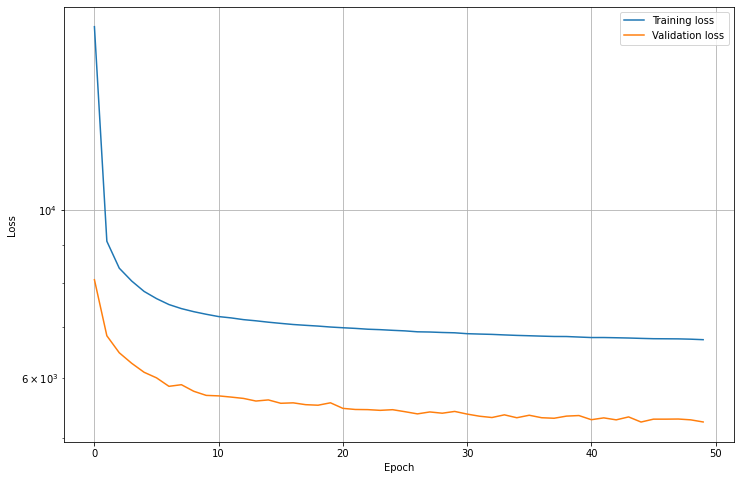

Average traininig  loss in the last 10 epochs: 6763.7578
Average validation loss in the last 10 epochs: 5281.5762


In [ ]:
#trainer.plot_losses()

In [ ]:
# set to evaluation mode
test_loss = trainer.val_epoch( dataloader=test_dataloader)
print('\n Average reconstruction error: %f' % (test_loss))


 Average reconstruction error: 410.089417


In [13]:
#torch.save(trainer.net.state_dict(), 'vae.pth')

## Load net params
vae.load_state_dict(torch.load('vae.pth'))

<All keys matched successfully>

## Visualize Reconstructions

In [ ]:
import torchvision.utils
vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.figure(figsize=(20,10))
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
imagegrid = torchvision.utils.make_grid(images[1:50],10,5)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(imagegrid, (1, 2, 0)))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
#plt.figure(figsize=(10,10))
visualise_output(images, vae)

## Generative properties of VAE

In [ ]:
vae = VariationalAutoencoder(latent_dims = 2)

print(vae.encoder)
print(vae.decoder)

vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256


train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


trainer = Training(net=vae,optimizer=optimizer,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader)

trainer.train(10)

In [ ]:
#torch.save(trainer.net.state_dict(), 'vae_2dim.pth')

## Load net params
vae.load_state_dict(torch.load('vae_2dim.pth'))

In [ ]:
# load a network that was trained with a 2d latent space
if vae.latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()